<a href="https://colab.research.google.com/github/Zdestrion/ML_pvt_repo/blob/master/NB_CNN_LC3_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Implementazione di Convolutional Neural Network, tuning degli iperparmetri, confronto con una CNN stato dell'arte + transfer learning  

### Informazioni ###

scopo: familiarizzare con l'utilizzo del tool Tensorflow/Keras per lo sviluppo di CNN 

applicazione: predizione temperatura di configurazioni del modello di Ising ferromagnetico 2D

DL tool: tensorflow/keras

### Modello di Ising 2D ###

dettagli (definizione teorica e simulazione) nella [nota](https://vixra.org/pdf/1710.0021v2.pdf).

È definito su un reticolo bidimensionale dall'Hamiltoniana 

$$ H = -J\sum_{\langle ij\rangle}S_{i}S_j,\qquad \qquad S_j\in\{\pm 1\} $$

in cui gli indici del reticolo $i,j$ sono associati ai primi vicini di un reticolo 2D quadrato di lato $L$, e $J$ è un parametro di scala arbitrario che definisce la scala dell'energia di interazione tra gli spin $S_i$.
Si utilizzano condizioni periodiche al contorno sul reticolo.

Si dimostra che questo sistema presenta una transizione di fase nel limite termodinamico da un sistea ordinato con tutti gli spin allineati (ferromagnete ordinato) a una fase disordinata con spin random, alla temperatura critica $T_c/J=1/\log(1+\sqrt{2})\approx 2.26$. 


**Dataset:**

10k configurazioni (simulate con termalizzazioni non complete in modo da avere un certo livello di "rumore") con $T/J$ uniforme in $[0,5]$ di un modello ising 2D su un reticolo $28\times 28$ simulato tramite un semplice Monte Carlo tipo Metropolis 

NOTA: le configurazioni sono 28x28 valori dello spin, le label sono la temperatura associata ad ogni configurazione.

In [0]:
# download del dataset:
!wget http://www.roma1.infn.it/~giagu/datasets/ising2_label.dat
!wget http://www.roma1.infn.it/~giagu/datasets/ising2_conf.dat

--2020-06-01 21:44:55--  http://www.roma1.infn.it/~giagu/datasets/ising2_label.dat
Resolving www.roma1.infn.it (www.roma1.infn.it)... 141.108.26.150, 141.108.26.1
Connecting to www.roma1.infn.it (www.roma1.infn.it)|141.108.26.150|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81025 (79K)
Saving to: ‘ising2_label.dat.2’

ising2_label.dat.2  100%[===================>]  79.13K   248KB/s    in 0.3s    

2020-06-01 21:44:56 (248 KB/s) - ‘ising2_label.dat.2’ saved [81025/81025]

--2020-06-01 21:44:57--  http://www.roma1.infn.it/~giagu/datasets/ising2_conf.dat
Resolving www.roma1.infn.it (www.roma1.infn.it)... 141.108.26.150, 141.108.26.1
Connecting to www.roma1.infn.it (www.roma1.infn.it)|141.108.26.150|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19060775 (18M)
Saving to: ‘ising2_conf.dat.2’

ising2_conf.dat.2   100%[===================>]  18.18M  9.30MB/s    in 2.0s    

2020-06-01 21:45:00 (9.30 MB/s) - ‘ising2_conf.dat.2’ saved [19060

### Procedura ###

Passi tipici nella costruzione di una procedura end-to-end per lo sviluppo di una CNN (o generica DNN):

1.   lettura e pre-processamento dei dati
2.   definizionedel modello di ANN e della sua architettura
3.   scelta dell'ottmizzatore e della funzione di loss
4.   training del modello
5.   misura delle prestazioni del modello su dati non utilizzati nel training (test data)
6.   modifica degli iperparametri per ottimizzare le prestazioni per il dataset specifico (hyperparameter tuning)

In [0]:
#import models & layers from TF/keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import make_axes_locatable

print(tf.__version__)

2.2.0


Le reti neurali non processano direttamente dati "raw" come per esempio immagini JPEG o file di testo, o file CSV. Si aspettano in input rappresentazioni numeriche vettorizzate e standardizzate


*   file con testo devono essere convertiti in tensori di stringhe, poi separati in parole, e infine ogni parola deve essere indicizzata e trasformata in tensori di interi

*   le immagini devono essere convertite in tenosri di numeri reali ed eventualmente normalizzate a vlaori piccoli (spesso in [0,1])

*   dati in formato CSV devono essere letti e decodificati (per esempio con pandas). Ogni feature poi eventualmente dovrebbe essere normalizzata (non obbligatorio ma utile) in modo da avere media zero e varianza unitaria

etc. etc.

Keras accetta input in forma di numpy array oopure in formati specializzati di tensorflow (tf dataset objects) utili nel caso di grandi campioni che non entrano in memoria e per i quali si deve attuare una lettura a batch dallo storage del disco rigido. 

Keras ha anche varie utility che permettono di leggere automaticamente immagini o file di testo e convertirli nei formati utili (vedere per esempio tf.keras.preprocessing.image_dataset_from_directory o tf.keras.preprocessing.text_dataset_from_directory). 

In questa esercitazione useremo semplicemente numpy

In [0]:
#leggiamo le configurazioni ising dal file usando numpy (10k esempi oguno da 28x28 spin)
data = np.loadtxt('ising2_conf.dat')
#riformattiamo i vettori in modo che abbiano la struttura di matrici di 28x28 spin
# (le configurazioni sono scritte nel file come 10000*28 righe ognuna di 28 elementi)
data = data.reshape(10000,28,28)
print('Formato data: ', data.shape)

#leggiamo le label associate:
labels = np.loadtxt('ising2_label.dat')
print('Formato labels:', labels.shape)

Formato data:  (10000, 28, 28)
Formato labels: (10000,)


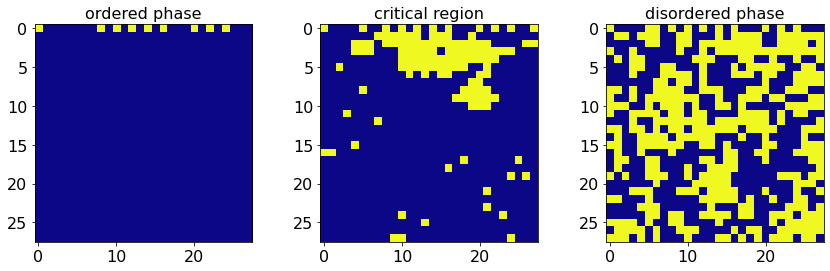

In [0]:
#Data esploration: visulaizzazione dei campioni
%matplotlib inline 

# set colourbar map
cmap_args=dict(cmap='plasma_r')

# selezioniamo configurazioni sotto la temperatura critica (stato ordinato), 
# sopra la temp. critica (stato disordinato), e intorno alla temperatura 
# critica (stato critico)
ord_sele = (labels < 2.0)
dis_sele = (labels > 2.5)
cri_sele = ((labels >= 2.0) & (labels <= 2.5))

# plot states
fig, axarr = plt.subplots(nrows=1, ncols=3)

axarr[0].imshow(data[ord_sele][1],**cmap_args)
axarr[0].set_title('ordered phase',fontsize=16)
axarr[0].tick_params(labelsize=16)

axarr[1].imshow(data[cri_sele][7],**cmap_args)
axarr[1].set_title('critical region',fontsize=16)
axarr[1].tick_params(labelsize=16)

axarr[2].imshow(data[dis_sele][5],**cmap_args)
axarr[2].set_title('disordered phase',fontsize=16)
axarr[2].tick_params(labelsize=16)

fig.subplots_adjust(right=2.0)

plt.show()

In [0]:
# Preprocessamento dei dati: 
# in questo caso specifico non serve normalizzare i dati visto che sono già valori 
# binari compresi nell'intervallo [-1,1]
# non è nemmeno necessario agire sulle label (T) per esempio convertendole in 
# formato vettori one-hot visto che siamo interesati ad addestrare la CNN per 
# una task di regressione (predire la temperatura di una configurazione del modello
# rappresentata da un'immagine binaria  

# unica cosa utile è quella di convertire in formato fp32 i valori degli spin (-1, 1):

data = data.astype('float32')
labels = labels.astype('float32')

# se avessimo voluto normalizzare le immagini tra [0,1]:
# o usare scikit-learn sklearn.preprocessing.MinMaxScaler
data_max = np.amax(data)
data_min = np.amin(data)
print('min/max data: %f / %f' % (data_min, data_max))
data_norm = (data.astype('float32')-data_min) / (data_max-data_min)
print('min/max normalized data: %f / %f' % (np.amin(data_norm), np.amax(data_norm)))

# se avessimo voluto normalizzare le immagini a media 0 e varianza 1
# o usare scikit-learn sklearn.preprocessing.normalize
from tensorflow.keras.layers.experimental.preprocessing import Normalization
normalizer = Normalization(axis=-1)
normalizer.adapt(data)
data_norm = normalizer(data)
print('var normalized data: %.4f' % np.var(data_norm))
print('mean normalized data: %.4f' % np.mean(data_norm))

min/max data: -1.000000 / 1.000000
min/max normalized data: 0.000000 / 1.000000
var normalized data: 1.0000
mean normalized data: -0.0000


In [0]:
# se avessimo voluto codificare le label usando one_hot encoding (builtin in keras)
# NOTA: non ha senso in questo caso con label target continui ...
# labels_onehot = keras.utils.to_categorical(labels)

In [0]:
# dividiamo il campione in training e test sets

from sklearn.model_selection import train_test_split
train_to_test_ratio=0.8 # training samples

X_train,X_test,Y_train,Y_test=train_test_split(data,labels,train_size=train_to_test_ratio)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(8000, 28, 28)
(2000, 28, 28)
(8000,)
(2000,)


**Creazione del Modello CNN**

Usiamo functional API di Keras

Model: "ising_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
ReLU_1 (ReLU)                (None, 26, 26, 32)        0         
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
ReLU_2 (ReLU)                (None, 11, 11, 64)        0         
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 5, 5, 64)          0 

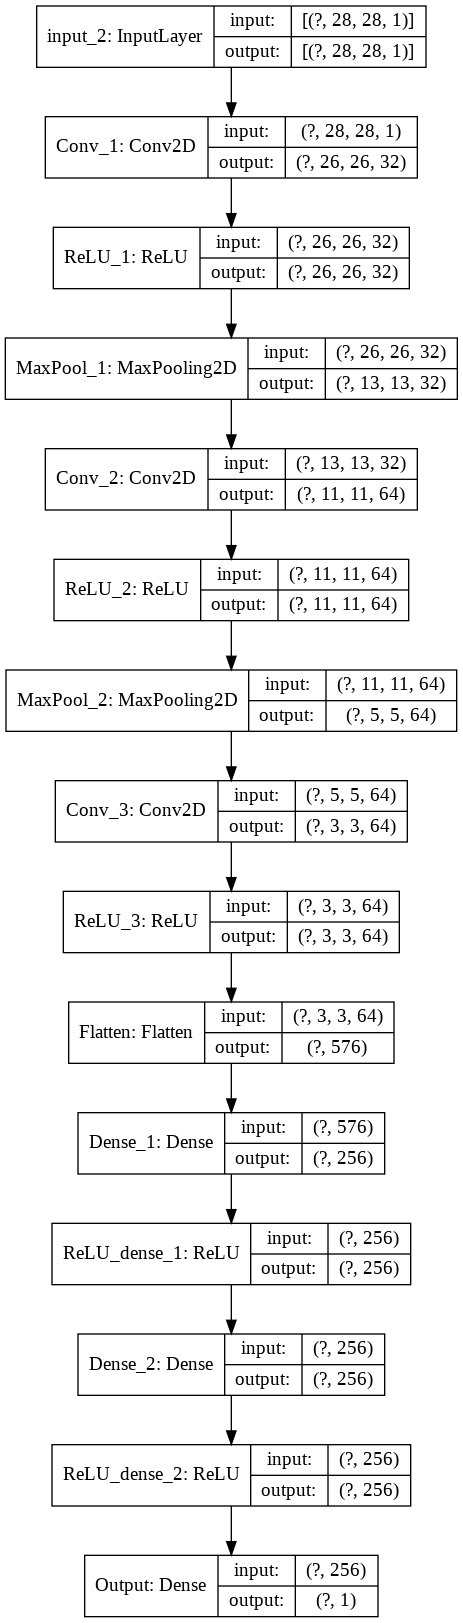

In [0]:
# Model definition (functional model)

# definizione input (tensori 28 spin x 28 spin x 1)
inputs = keras.Input(shape=(28,28,1))

# Data Augmentation
# è spesso utile applicare variazioni random ai dati che siano coerenti con le 
# simmetrie del problema per rendere il modello più robusto e con maggiore 
# capacità di generalizzazione
# In questo caso per esempio e' possibile fare dei filipping random orizzontali 
# o verticali dei pixel (spin) senza cambiare il contenuto fisico delle config.
# Se lo volessimo fare in TF/keras basta generare un layer di data-augmentation

data_augmentation = keras.Sequential([
  keras.layers.experimental.preprocessing.RandomFlip()
], name='DataAugm')

#ed aggiungerlo al modello come primo layer dopo l'input ...
# NOTA: il sistema è intelligente e le trasformazioni vengono atuate SOLO durante 
# il training ma non durante uso del modello in prediction/test 

# Image augmentation block scomentare la riga che segue (e commentare la successiva) 
# per attivarlo
#x = data_augmentation(inputs)
x = inputs

# CNN costituita da 3 blocchi convoluzionali per la feature selection, seguiti 
# da una rete densa come classificatore

#
# singolo blocco convoluzionale: conv2D + maxPooling 
# attvazione: ReLu

# primo blocco convoluzionale: x -> Conv2D -> x -> ReLU -> x -> MaxPooling2D
#tf.keras.layers.Conv2D(
#    filters, kernel_size, strides=(1, 1), padding='valid', data_format=None,
#    dilation_rate=(1, 1), activation=None, use_bias=True,
#    kernel_initializer='glorot_uniform', bias_initializer='zeros',
#    kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
#    kernel_constraint=None, bias_constraint=None, **kwargs
#)
#tf.keras.layers.ReLU(
#    max_value=None, negative_slope=0, threshold=0, **kwargs
#)
#tf.keras.layers.MaxPool2D(
#    pool_size=(2, 2), strides=None, padding='valid', data_format=None, **kwargs
#)
# NOTA: padding = 'valid' -> no padding,  = 'same' -> padding aggiunto per non 
# ridurre la size dell'immagine dopo lapplicazione del filtro

#
# primo blocco Convoluzionale
x = keras.layers.Conv2D(32, kernel_size=(3,3), name='Conv_1')(x)
x = keras.layers.ReLU(name='ReLU_1')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_1')(x)

# secondo blocco convoluzionale
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_2')(x)
x = keras.layers.ReLU(name='ReLU_2')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_2')(x)

# terzo blocco convoluzionale (non applichiamo il maxpooling per non ridurre 
# troppo la dimensione dell'output x)
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_3')(x)
x = keras.layers.ReLU(name='ReLU_3')(x)

# appiattimento del tensore x di uscita dell'ultimo layer convoluzionale in un 
# vettore piatto come input per la rete densa

x = keras.layers.Flatten(name='Flatten')(x)

# rete densa: 2 layer hidden densi da 256 neuroni con attivazione ReLU + 1 
# layer di uscita costituito da 1 neurone con funzione di attivazione lineare
# che produce in output la stima della temperatura associata alla configurazione
# in input

# Layer denso in Keras
#tf.keras.layers.Dense(
#    units, activation=None, use_bias=True, kernel_initializer='glorot_uniform',
#    bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None,
#    activity_regularizer=None, kernel_constraint=None, bias_constraint=None,
#    **kwargs
#)
x = keras.layers.Dense(256, name='Dense_1')(x)
x = keras.layers.ReLU(name='ReLU_dense_1')(x)
x = keras.layers.Dense(256, name='Dense_2')(x)
x = keras.layers.ReLU(name='ReLU_dense_2')(x)
outputs = keras.layers.Dense(1, name='Output')(x)

#definizione del modello
model = keras.Model(inputs=inputs, outputs=outputs, name='ising_CNN')

#printout il summary del modello
model.summary()

# struttura el modello
keras.utils.plot_model(model, show_shapes=True)

In [0]:
#Compilazione del Modello

# Definizione dei parametri di training del modello:
# * Loss function: 
# * Optimizer:
# * Metric: 

# Parametri:

# learning rate per Adam
LR_ST=1e-3

# Ottimizzatore: 
#adam: adaptive moment estimation (SGD con learning adattivo del gradiente e 
# del momento secondo + momentum )
#tf.keras.optimizers.Adam(
#    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
#    name='Adam', **kwargs
#)

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)

# Loss function:
# siamo interessati ad una task di regressione: una loss appropriata è la MSE
# (mean squared error) che minimizza la distanza quadratica tra predizione 
# della rete e target = 1/N sum (y_pred - t_true)^2
# loss: mse

mse = tf.keras.losses.MeanSquaredError()

# Metrica:
# visto che la MSE viene monitorata come loss, può essere utile monitorare la 
# MAE (mean absolute error) = 1/N sum |y_pred - t_true|
# metric: mae

mae = tf.keras.metrics.MeanAbsoluteError()

# Eagerly RUN:
# di default Tensorflow ottimizza in modo spinto il modello che abbiamo progettato
# e trasforma il modello in un grafo diretto acicliclo computazionale altamente 
# ottimizzato per girare nel minor tempo possibile. Questo significa che non è 
# il codice python che abbiamo scritto sopra ad essere in realtà esegeuito. Questo
# può creare difficoltà con il debugging se ci sono problemi. Se sidesidera 
# eseguire esattamente il python scritto basta settare run_eagerly=True. Il prezzo
# da pagare è una esecuzioen estremamente più lenta (is usa solo in debug) 

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse,
              metrics=[mae],
              run_eagerly=EAGERLY)

In [0]:
# TRAINING

# Parametr: frazione eventi validation set, batch size, numero epoche, ...

# Callbacks:
# tramite le callbacks possiamo interagire durante il run-time con il modello.
# Per esempio possiamo modificare il larnign rate facendolo decadere (diminuire) 
# nel tempo, o possiamo dire al modello di salvare i pesi ad ogni epoca o quando 
# la validation loss raggiunge il suo valore minimo etc..
# Le callback vengono chiamate all'inizio di ogni epoca o all'inizio di ogni 
# mini-batch a seconda dello scopo ...

# callback per avere un leraning rate variabile

# Definisco una funzione che mantiene il learning rate costante a LR_ST per le 
# prime 10 epoche e poi lo diminuisce esponenzialmente
def lr_decay(epoch):
  if epoch < 10:
    return LR_ST
  else:
    return LR_ST * tf.math.exp(0.2 * (10 - epoch))

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

# callback per salvare il modello (solo i pesi in queto caso) ad ogni epoca
model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='mycnn_{epoch}',
        save_weights_only=True, 
        save_freq='epoch')

# metto tutte le callback in una lista
#callbacks = [ lr_scheduler, model_checkpoint ]
callbacks = [ model_checkpoint ]
    

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 0s 7ms/step - loss: 0.7848 - mean_absolute_error: 0.6360 - val_loss: 0.2516 - val_mean_absolute_error: 0.4262
Epoch 2/30
50/50 [==============================] - 0s 6ms/step - loss: 0.2346 - mean_absolute_error: 0.4115 - val_loss: 0.2119 - val_mean_absolute_error: 0.3818
Epoch 3/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1910 - mean_absolute_error: 0.3580 - val_loss: 0.1916 - val_mean_absolute_error: 0.3588
Epoch 4/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1568 - mean_absolute_error: 0.3179 - val_loss: 0.1296 - val_mean_absolute_error: 0.2952
Epoch 5/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1266 - mean_absolute_error: 0.2809 - val_loss: 0.1209 - val_mean_absolute_error: 0.2777
Epoch 6/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1104 - mean_absolute_error: 0.2604 - val_loss: 0.1100 - val_mean_absolute_error: 0.2644
Epoch 7/30
50/50 [==========

In [0]:
# carichiamo i parametri del modello migliore sul validation set 
# (i.e. quello che aveva la minore loss in validazione) in questo caso l'epoca 29
model.load_weights('mycnn_29')

In [0]:
#checks accuracy and loss on test sample

test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.0923 - mean_absolute_error: 0.2265

Test loss (MSE): 0.09228651225566864

Test MAE: 0.22649239003658295


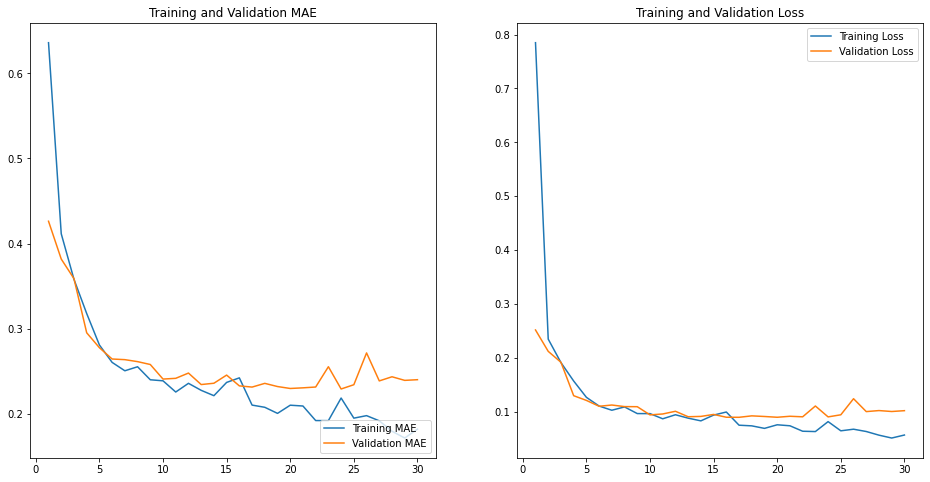

In [0]:
#plot della loss e della MAE durante il training

mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
#esempio uso della rete in predizione

predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)


Predicted vs True T: 0.606393 VS 0.102209 Diff= 0.504184
Predicted vs True T: 1.160584 VS 1.384770 Diff= -0.224186
Predicted vs True T: 2.406997 VS 2.531030 Diff= -0.124033
Predicted vs True T: 1.181251 VS 1.388530 Diff= -0.207279
Predicted vs True T: 3.967650 VS 3.865890 Diff= 0.101760
Predicted vs True T: 3.496956 VS 3.281270 Diff= 0.215686
Predicted vs True T: 4.283673 VS 4.444750 Diff= -0.161077
Predicted vs True T: 3.020986 VS 3.063080 Diff= -0.042094
Predicted vs True T: 3.479269 VS 3.156730 Diff= 0.322539
Predicted vs True T: 2.544855 VS 2.829210 Diff= -0.284355
Sample MAE:  [0.21871929]


In [0]:
#Vediamo l'accuracy della rete usata come classificatore per selezionare configurazioni con T><Tc

T_c=2.26 # Temperatura critica

# predizioni della CNN sull'intero campione di Test
predictions = model.predict(X_test)


# conto i casi in cui la T predetta e la T true sono emtrambe <T_c o >= T_c
N_ord_corrette = 0 
N_dis_corrette = 0
N_all = 0
for i in range(predictions.shape[0]):
  if ((predictions[i] < T_c) & (Y_test[i] < T_c)):
    N_ord_corrette = N_ord_corrette + 1
  if ((predictions[i] >= T_c) & (Y_test[i] >= T_c)):
    N_dis_corrette = N_dis_corrette + 1

N_all = Y_test.shape[0]   

accuracy = (N_ord_corrette+N_dis_corrette)/N_all
print('Accuracy is: ', accuracy)



Accuracy is:  0.98


# **Compiti:** 

1.   ripetere il training attivando la call-back del learning rate con decay e valutare se ci sono miglioramenti
2.   ripetere il training attivando il layer con data-augmentation e valutare se ci sono miglioramenti
3.   provate a usare funzioni di attivazione diverse da ReLU: *keras.layers.Activation('tanh'), keras.layers.LeakyReLU(), keras.layers.ELU()*, ...
3.   provare ad implementare una semplice procedura di ottimizzazione degli iperparametri usando Keras Tuner (vedi istruzioni nel blocco successivo)
4.   provare ad inserire nella rete *batch normalisation* layers prima dei layer ReLu (vedi spiegazione e istruzioni alla fine del notebook)

#Esercizio 1: Learning rate decay

In [0]:
#common functions definition
def plotcompare (history, comp1 = '', comp2 = ''):
  plt.close()
  mae_lrd = history.history['mean_absolute_error']
  val_mae_lrd = history.history['val_mean_absolute_error']

  loss_lrd=history.history['loss']
  val_loss_lrd=history.history['val_loss']

  #Calculating the minimum reached
  min_mae = np.amin(mae)
  min_val_mae = np.amin(val_mae)

  min_mae_lrd = np.amin(mae_lrd)
  min_val_mae_lrd = np.amin(val_mae_lrd)

  min_loss = np.amin(loss)
  min_val_loss = np.amin(val_loss)

  min_loss_lrd = np.amin(loss_lrd)
  min_val_loss_lrd = np.amin(val_loss_lrd)

  epochs_range = range(1, len(loss) + 1)

  fig, axarr = plt.subplots(nrows=2, ncols=2, figsize = ((8*2,8*2)))

  axarr[0,0].plot(epochs_range, mae, label='Training MAE, min = %.3f'%min_mae)
  axarr[0,0].plot(epochs_range, val_mae, label='Validation MAE, min = %.3f'%min_val_mae)
  axarr[0,0].legend(loc='upper right')
  axarr[0,0].set_title('Training and Validation MAE: %s'%comp1)

  axarr[0,1].plot(epochs_range, mae_lrd, label='Training MAE, min = %.3f'%min_mae_lrd)
  axarr[0,1].plot(epochs_range, val_mae_lrd, label='Validation MAE, min = %.3f'%min_val_mae_lrd)
  axarr[0,1].legend(loc='upper right')
  axarr[0,1].set_title('Training and Validation MAE: %s'%comp2)

  axarr[1,0].plot(epochs_range, loss, label='Training Loss, min = %.3f'%min_loss)
  axarr[1,0].plot(epochs_range, val_loss, label='Validation Loss, min = %.3f'%min_val_loss)
  axarr[1,0].legend(loc='upper right')
  axarr[1,0].set_title('Training and Validation Loss: %s'%comp1)

  axarr[1,1].plot(epochs_range, loss_lrd, label='Training Loss, min = %.3f'%min_loss_lrd)
  axarr[1,1].plot(epochs_range, val_loss_lrd, label='Validation Loss, min = %.3f'%min_val_loss_lrd)
  axarr[1,1].legend(loc='upper right')
  axarr[1,1].set_title('Training and Validation Loss: %s'%comp2)
  plt.show()

def lr_decay(epoch):
  if epoch < 10:
    return LR_ST
  else:
    return LR_ST * tf.math.exp(0.2 * (10 - epoch))

def create_convolution(activation = 'ReLU', n_conv = 3, n_pool = 2, n_dense = 2, conv2D = 32, density = 256, augmentation = 'TRUE'):
  inputs = keras.Input(shape=(28,28,1))

  if augmentation == 'TRUE':
    data_augmentation = keras.Sequential([
      keras.layers.experimental.preprocessing.RandomFlip()
    ], name='DataAugm')
    x = data_augmentation(inputs)
  elif augmentation == 'FALSE': x = inputs
  else: 
    print('Error! "augmentation" must be a boolean variable.')
    return None

  #Normal layers
  for index in range(n_conv):
    nameconv = 'Conv_'+str(index+1) 
    nameact = activation+'_'+str(index+1)
    namepool = 'MaxPool_'+str(index+1)
    
    if index == 0:
      x = keras.layers.Conv2D(conv2D, kernel_size=(3,3), name=nameconv)(x)
    else: 
      x = keras.layers.Conv2D(conv2D*2, kernel_size=(3,3), name=nameconv)(x)
    
    if activation == 'ReLU':
      x = keras.layers.ReLU(name=nameact)(x)
    elif activation == 'ELU':
      x = keras.layers.ELU(name=nameact)(x)
    elif activation == 'LeakyReLU':
      x = keras.layers.LeakyReLU(name=nameact)(x)
    elif activation == 'tanh':
      x = keras.layers.Activation(activation,name=nameact)(x)
    else: 
      print('Error! Activation function is not valid')
      return None

    if index < n_pool:
      x = keras.layers.MaxPool2D((2,2), name=namepool)(x)

  x = keras.layers.Flatten(name='Flatten')(x)

  #Dense layers
  for index in range(n_dense):
    namedense = 'Dense_'+str(index+1) 
    nameact = activation+'_Dense_'+str(index+1)

    x = keras.layers.Dense(density, name=namedense)(x)
    if activation == 'ReLU':
      x = keras.layers.ReLU(name=nameact)(x)
    elif activation == 'ELU':
      x = keras.layers.ELU(name=nameact)(x)
    elif activation == 'LeakyReLU':
      x = keras.layers.LeakyReLU(name=nameact)(x)
    elif activation == 'tanh':
      x = keras.layers.Activation(activation,name=nameact)(x)
    else: 
      print('Error! Activation function is not valid')
      return None

  outputs = keras.layers.Dense(1, name='Output')(x)
  model = keras.Model(inputs=inputs, outputs=outputs, name='ising_CNN')
 
  return outputs, model

#Accuracy function
def accuracy_func(model,X_test):
  T_c=2.26
  # CNN prediction on the complete test set
  predictions = model.predict(X_test)

  N_ord_corrette = 0 
  N_dis_corrette = 0
  N_all = 0
  for i in range(predictions.shape[0]):
    if ((predictions[i] < T_c) & (Y_test[i] < T_c)):
      N_ord_corrette = N_ord_corrette + 1
    if ((predictions[i] >= T_c) & (Y_test[i] >= T_c)):
      N_dis_corrette = N_dis_corrette + 1

  N_all = Y_test.shape[0]   

  accuracy = (N_ord_corrette+N_dis_corrette)/N_all
  print('Accuracy is: ', accuracy)  


In [0]:
outputs, model = create_convolution(augmentation='FALSE')

In [0]:
#Compilation of the model
LR_ST=1e-3

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)
#Metrics
mse_lrd = tf.keras.losses.MeanSquaredError()
mae_lrd = tf.keras.metrics.MeanAbsoluteError()

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse_lrd,
              metrics=[mae_lrd],
              run_eagerly=EAGERLY)

In [0]:
#Training and callback modification
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath = 'best_epoch',
        verbose = 0,
        save_weights_only = True, 
        save_freq = 'epoch',
        save_best_only = True,
        mode ='min')

callbacks = [ lr_scheduler, model_checkpoint ]

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 0s 7ms/step - loss: 0.8707 - mean_absolute_error: 0.6587 - val_loss: 0.2410 - val_mean_absolute_error: 0.4155 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 0s 6ms/step - loss: 0.2374 - mean_absolute_error: 0.4149 - val_loss: 0.2239 - val_mean_absolute_error: 0.4015 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 0s 5ms/step - loss: 0.2185 - mean_absolute_error: 0.3970 - val_loss: 0.2003 - val_mean_absolute_error: 0.3834 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1860 - mean_absolute_error: 0.3633 - val_loss: 0.1608 - val_mean_absolute_error: 0.3319 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1491 - mean_absolute_error: 0.3150 - val_loss: 0.1269 - val_mean_absolute_error: 0.2873 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1261 - mean_absolute_error: 0.2837 - val_loss: 0.15

In [0]:
model.load_weights('best_epoch')

#Accuracy check
test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.0802 - mean_absolute_error: 0.2146

Test loss (MSE): 0.08018156886100769

Test MAE: 0.21459762752056122


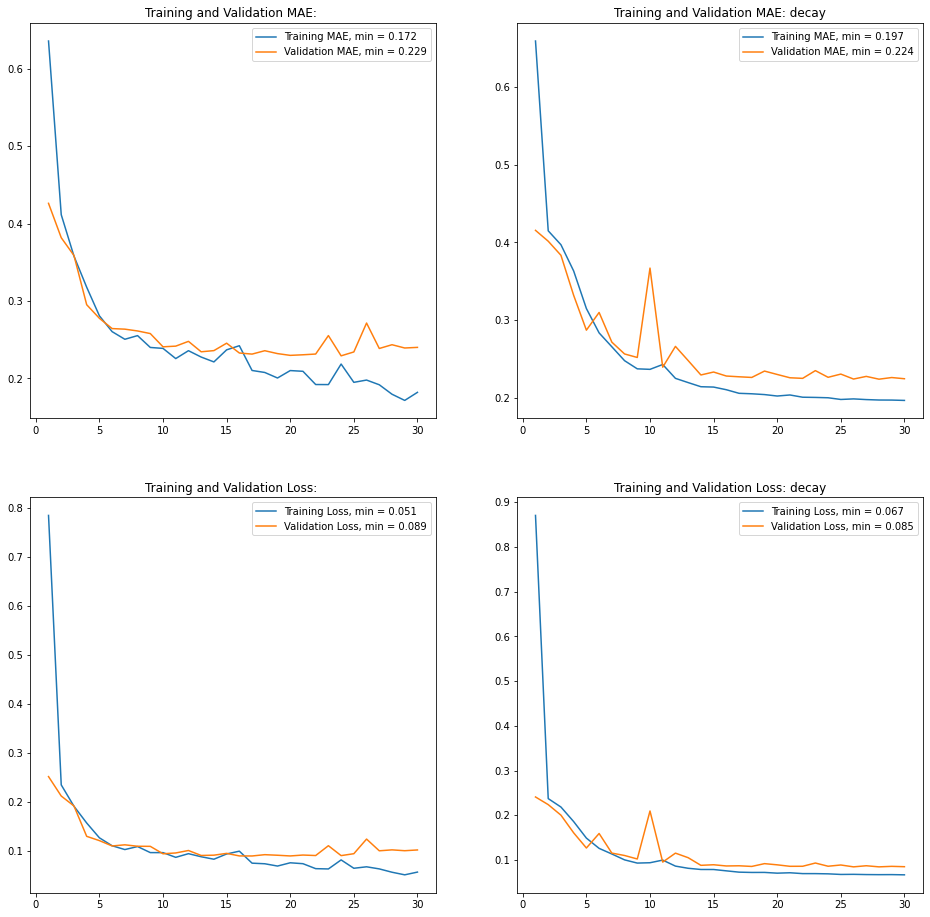

In [0]:
#Plot of the loss function 
plotcompare(history, comp2='decay')

In [0]:
#Prediction usage
predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)

Predicted vs True T: 0.619693 VS 0.102209 Diff= 0.517483
Predicted vs True T: 1.355520 VS 1.384770 Diff= -0.029250
Predicted vs True T: 2.860002 VS 2.531030 Diff= 0.328972
Predicted vs True T: 1.312787 VS 1.388530 Diff= -0.075743
Predicted vs True T: 4.286118 VS 3.865890 Diff= 0.420228
Predicted vs True T: 3.029152 VS 3.281270 Diff= -0.252118
Predicted vs True T: 4.355260 VS 4.444750 Diff= -0.089489
Predicted vs True T: 2.898786 VS 3.063080 Diff= -0.164294
Predicted vs True T: 3.504969 VS 3.156730 Diff= 0.348239
Predicted vs True T: 2.671926 VS 2.829210 Diff= -0.157284
Sample MAE:  [0.23831007]


In [0]:
#Accuracy
accuracy_func(model,X_test)

Accuracy is:  0.9845


#Esercizio 2: Data augmentation

In [0]:
outputs, model = create_convolution()

In [0]:
#Compilation of the model
LR_ST=1e-3

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)
#Metrics
mse_lrd = tf.keras.losses.MeanSquaredError()
mae_lrd = tf.keras.metrics.MeanAbsoluteError()

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse_lrd,
              metrics=[mae_lrd],
              run_eagerly=EAGERLY)

In [0]:
#Training and callback modification
model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath = 'best_epoch',
        verbose = 0,
        save_weights_only = True, 
        save_freq = 'epoch',
        save_best_only = True,
        mode ='min')

callbacks = [ model_checkpoint ]

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 0s 7ms/step - loss: 1.0452 - mean_absolute_error: 0.7163 - val_loss: 0.2519 - val_mean_absolute_error: 0.4184
Epoch 2/30
50/50 [==============================] - 0s 5ms/step - loss: 0.2191 - mean_absolute_error: 0.3958 - val_loss: 0.1853 - val_mean_absolute_error: 0.3604
Epoch 3/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1597 - mean_absolute_error: 0.3288 - val_loss: 0.1381 - val_mean_absolute_error: 0.3023
Epoch 4/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1372 - mean_absolute_error: 0.2977 - val_loss: 0.1597 - val_mean_absolute_error: 0.3236
Epoch 5/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1248 - mean_absolute_error: 0.2825 - val_loss: 0.1180 - val_mean_absolute_error: 0.2749
Epoch 6/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1229 - mean_absolute_error: 0.2811 - val_loss: 0.1197 - val_mean_absolute_error: 0.2761
Epoch 7/30
50/50 [==========

In [0]:
model.load_weights('best_epoch')

#Accuracy check
test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.0790 - mean_absolute_error: 0.2133

Test loss (MSE): 0.07899226993322372

Test MAE: 0.21330980956554413


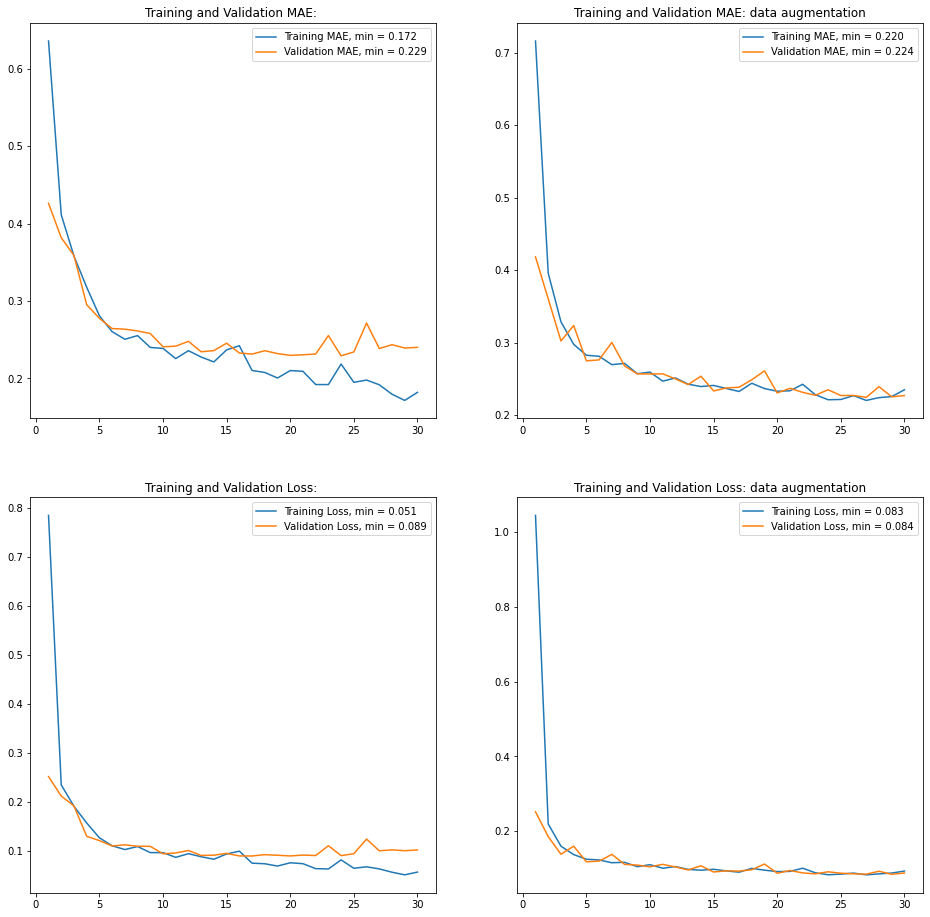

In [0]:
#Plot of the loss function 
plotcompare(history, comp2='data augmentation')

In [0]:
#Prediction usage
predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)

Predicted vs True T: 0.682114 VS 0.102209 Diff= 0.579905
Predicted vs True T: 1.231787 VS 1.384770 Diff= -0.152983
Predicted vs True T: 2.491627 VS 2.531030 Diff= -0.039402
Predicted vs True T: 1.239551 VS 1.388530 Diff= -0.148979
Predicted vs True T: 4.056846 VS 3.865890 Diff= 0.190956
Predicted vs True T: 3.274826 VS 3.281270 Diff= -0.006444
Predicted vs True T: 4.502610 VS 4.444750 Diff= 0.057860
Predicted vs True T: 3.013927 VS 3.063080 Diff= -0.049154
Predicted vs True T: 3.789381 VS 3.156730 Diff= 0.632651
Predicted vs True T: 2.745313 VS 2.829210 Diff= -0.083897
Sample MAE:  [0.19422315]


In [0]:
#Accuracy
accuracy_func(model,X_test)

Accuracy is:  0.9795


#Esercizio 2.1: Learning rate decay + data augmentation

In [0]:
outputs, model = create_convolution()

In [0]:
#Compilation of the model
LR_ST=1e-3

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)
#Metrics
mse_lrd = tf.keras.losses.MeanSquaredError()
mae_lrd = tf.keras.metrics.MeanAbsoluteError()

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse_lrd,
              metrics=[mae_lrd],
              run_eagerly=EAGERLY)

In [0]:
#Training and callback modification
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath = 'best_epoch',
        verbose = 0,
        save_weights_only = True, 
        save_freq = 'epoch',
        save_best_only = True,
        mode ='min')

callbacks = [ lr_scheduler, model_checkpoint ]

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 0s 8ms/step - loss: 0.7116 - mean_absolute_error: 0.6027 - val_loss: 0.2433 - val_mean_absolute_error: 0.4193 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 0s 5ms/step - loss: 0.2364 - mean_absolute_error: 0.4106 - val_loss: 0.2050 - val_mean_absolute_error: 0.3782 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1855 - mean_absolute_error: 0.3568 - val_loss: 0.1716 - val_mean_absolute_error: 0.3433 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1664 - mean_absolute_error: 0.3344 - val_loss: 0.1502 - val_mean_absolute_error: 0.3214 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1392 - mean_absolute_error: 0.3038 - val_loss: 0.1308 - val_mean_absolute_error: 0.2931 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1281 - mean_absolute_error: 0.2857 - val_loss: 0.11

In [0]:
model.load_weights('best_epoch')

#Accuracy check
test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.0756 - mean_absolute_error: 0.2084

Test loss (MSE): 0.07563261687755585

Test MAE: 0.2084364891052246


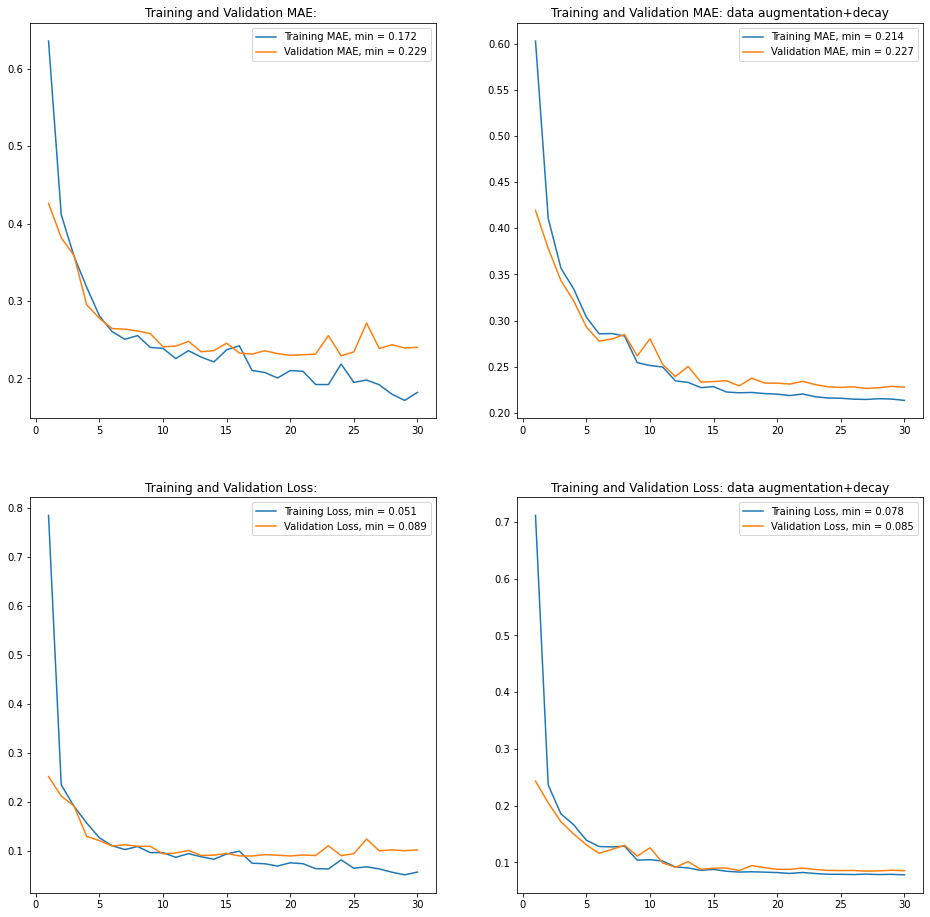

In [0]:
#Plot of the loss function 
plotcompare(history, comp2='data augmentation+decay')

In [0]:
#Prediction usage
predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)

Predicted vs True T: 0.657272 VS 0.102209 Diff= 0.555063
Predicted vs True T: 1.266411 VS 1.384770 Diff= -0.118359
Predicted vs True T: 2.555588 VS 2.531030 Diff= 0.024558
Predicted vs True T: 1.298441 VS 1.388530 Diff= -0.090089
Predicted vs True T: 4.162062 VS 3.865890 Diff= 0.296172
Predicted vs True T: 2.985763 VS 3.281270 Diff= -0.295507
Predicted vs True T: 4.341378 VS 4.444750 Diff= -0.103372
Predicted vs True T: 2.926993 VS 3.063080 Diff= -0.136087
Predicted vs True T: 3.526954 VS 3.156730 Diff= 0.370224
Predicted vs True T: 2.752279 VS 2.829210 Diff= -0.076931
Sample MAE:  [0.2066361]


In [0]:
#Accuracy
accuracy_func(model,X_test)

Accuracy is:  0.9835


#Esercizio 3: Funzioni di attivazioni differenti
#3.1: tanh


In [0]:
outputs, model = create_convolution(activation='tanh')

In [0]:
#Compilation of the model
LR_ST=1e-3

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)
#Metrics
mse_lrd = tf.keras.losses.MeanSquaredError()
mae_lrd = tf.keras.metrics.MeanAbsoluteError()

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse_lrd,
              metrics=[mae_lrd],
              run_eagerly=EAGERLY)

In [0]:
#Training and callback modification
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath = 'best_epoch',
        verbose = 0,
        save_weights_only = True, 
        save_freq = 'epoch',
        save_best_only = True,
        mode ='min')

callbacks = [ lr_scheduler, model_checkpoint ]

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 0s 8ms/step - loss: 0.7016 - mean_absolute_error: 0.6180 - val_loss: 0.2358 - val_mean_absolute_error: 0.4129 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 0s 6ms/step - loss: 0.2094 - mean_absolute_error: 0.3778 - val_loss: 0.1705 - val_mean_absolute_error: 0.3411 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1951 - mean_absolute_error: 0.3563 - val_loss: 0.2416 - val_mean_absolute_error: 0.3970 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1546 - mean_absolute_error: 0.3140 - val_loss: 0.1487 - val_mean_absolute_error: 0.3117 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1409 - mean_absolute_error: 0.2991 - val_loss: 0.1356 - val_mean_absolute_error: 0.2936 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1333 - mean_absolute_error: 0.2885 - val_loss: 0.12

In [0]:
model.load_weights('best_epoch')

#Accuracy check
test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.0849 - mean_absolute_error: 0.2219

Test loss (MSE): 0.08488112688064575

Test MAE: 0.22189833223819733


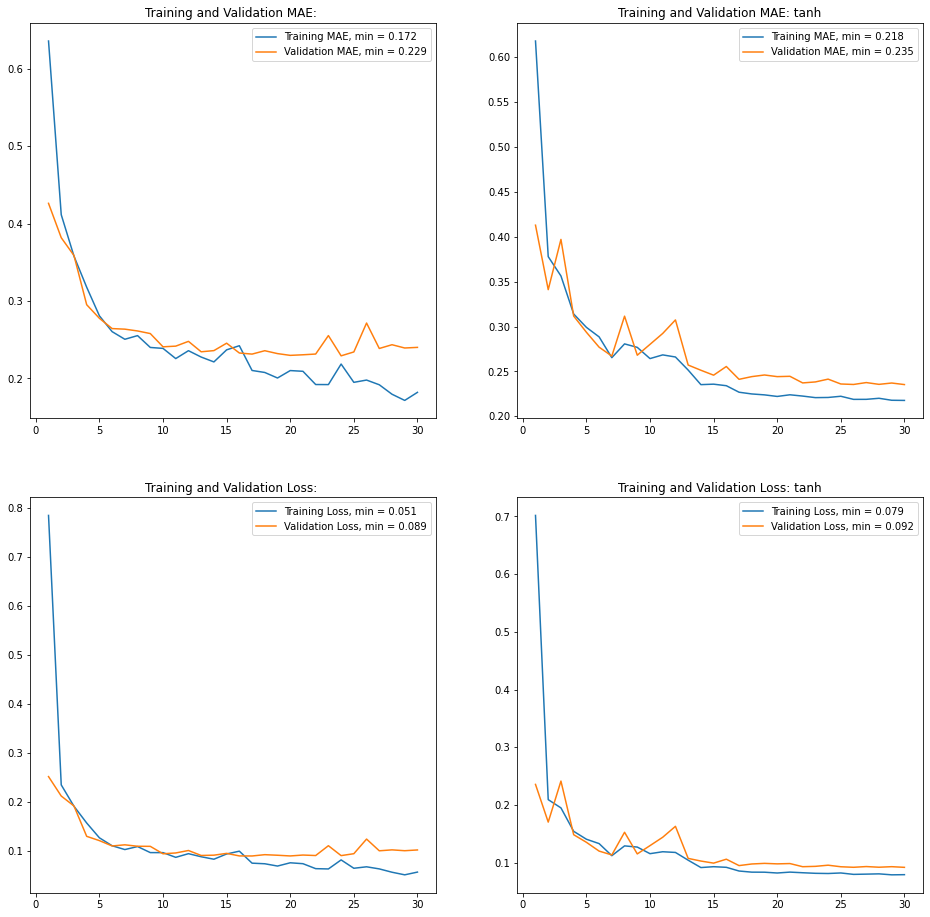

In [0]:
#Plot of the loss function 
plotcompare(history, comp2 = 'tanh')

In [0]:
#Prediction usage
predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)

Predicted vs True T: 0.716144 VS 0.102209 Diff= 0.613935
Predicted vs True T: 1.214938 VS 1.384770 Diff= -0.169832
Predicted vs True T: 2.701468 VS 2.531030 Diff= 0.170439
Predicted vs True T: 1.213653 VS 1.388530 Diff= -0.174877
Predicted vs True T: 4.207308 VS 3.865890 Diff= 0.341418
Predicted vs True T: 3.103394 VS 3.281270 Diff= -0.177876
Predicted vs True T: 4.471118 VS 4.444750 Diff= 0.026368
Predicted vs True T: 3.052765 VS 3.063080 Diff= -0.010315
Predicted vs True T: 3.631494 VS 3.156730 Diff= 0.474764
Predicted vs True T: 2.695098 VS 2.829210 Diff= -0.134112
Sample MAE:  [0.22939368]


In [0]:
#Accuracy
accuracy_func(model,X_test)

Accuracy is:  0.9835


#3.2 Leaky ReLU:

In [0]:
outputs, model = create_convolution(activation='LeakyReLU')

In [0]:
#Compilation of the model
LR_ST=1e-3

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)
#Metrics
mse_lrd = tf.keras.losses.MeanSquaredError()
mae_lrd = tf.keras.metrics.MeanAbsoluteError()

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse_lrd,
              metrics=[mae_lrd],
              run_eagerly=EAGERLY)

In [0]:
#Training and callback modification
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath = 'best_epoch',
        verbose = 0,
        save_weights_only = True, 
        save_freq = 'epoch',
        save_best_only = True,
        mode ='min')

callbacks = [ lr_scheduler, model_checkpoint ]

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 0s 8ms/step - loss: 0.4924 - mean_absolute_error: 0.5136 - val_loss: 0.2226 - val_mean_absolute_error: 0.4035 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 1s 11ms/step - loss: 0.1939 - mean_absolute_error: 0.3671 - val_loss: 0.1752 - val_mean_absolute_error: 0.3349 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1498 - mean_absolute_error: 0.3134 - val_loss: 0.1604 - val_mean_absolute_error: 0.3310 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1378 - mean_absolute_error: 0.2976 - val_loss: 0.1257 - val_mean_absolute_error: 0.2851 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1373 - mean_absolute_error: 0.2949 - val_loss: 0.1295 - val_mean_absolute_error: 0.2921 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1208 - mean_absolute_error: 0.2745 - val_loss: 0.1

In [0]:
model.load_weights('best_epoch')

#Accuracy check
test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.0780 - mean_absolute_error: 0.2102

Test loss (MSE): 0.0780334398150444

Test MAE: 0.21023748815059662


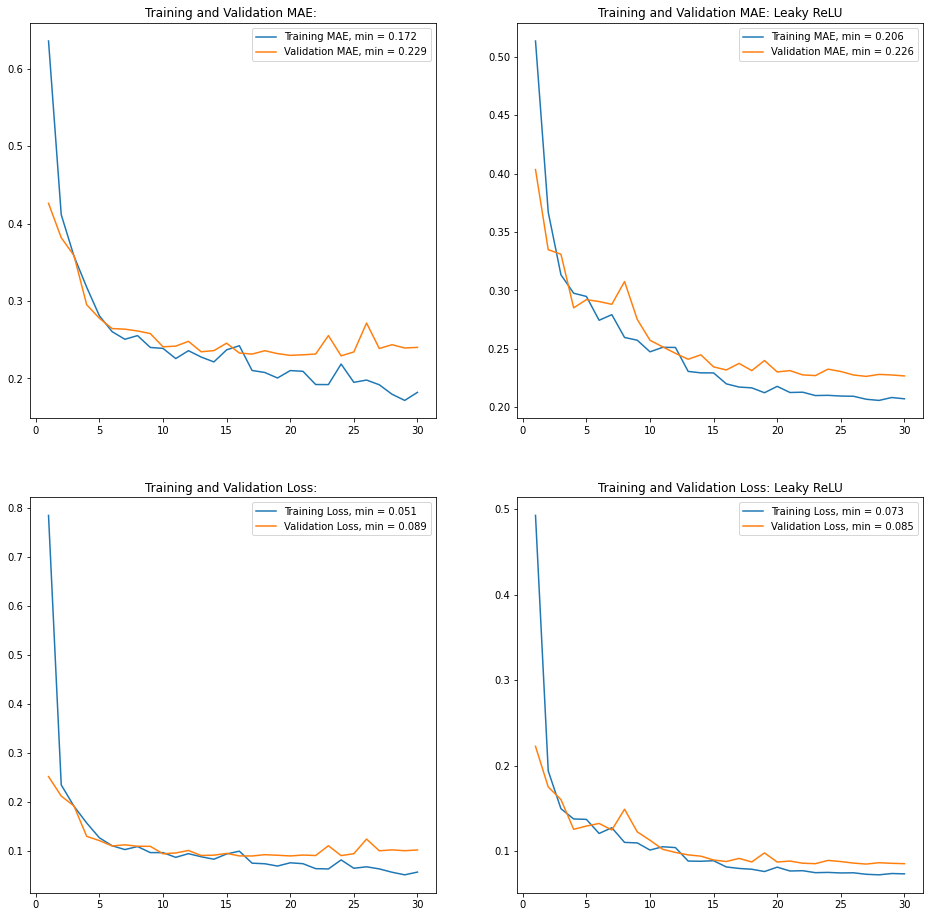

In [0]:
#Plot of the loss function 
plotcompare(history, comp2 = 'Leaky ReLU')

In [0]:
#Prediction usage
predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)

Predicted vs True T: 0.657147 VS 0.102209 Diff= 0.554938
Predicted vs True T: 1.295698 VS 1.384770 Diff= -0.089072
Predicted vs True T: 2.616160 VS 2.531030 Diff= 0.085130
Predicted vs True T: 1.250057 VS 1.388530 Diff= -0.138473
Predicted vs True T: 4.120549 VS 3.865890 Diff= 0.254659
Predicted vs True T: 2.941544 VS 3.281270 Diff= -0.339726
Predicted vs True T: 4.272003 VS 4.444750 Diff= -0.172747
Predicted vs True T: 3.211375 VS 3.063080 Diff= 0.148295
Predicted vs True T: 3.560577 VS 3.156730 Diff= 0.403847
Predicted vs True T: 2.735089 VS 2.829210 Diff= -0.094121
Sample MAE:  [0.22810094]


In [0]:
#Accuracy
accuracy_func(model,X_test)

Accuracy is:  0.9875


#3.3 ELU:

In [0]:
outputs, model = create_convolution(activation='ELU')

In [0]:
#Compilation of the model
LR_ST=1e-3

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)
#Metrics
mse_lrd = tf.keras.losses.MeanSquaredError()
mae_lrd = tf.keras.metrics.MeanAbsoluteError()

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse_lrd,
              metrics=[mae_lrd],
              run_eagerly=EAGERLY)

In [0]:
#Training and callback modification
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath = 'best_epoch',
        verbose = 0,
        save_weights_only = True, 
        save_freq = 'epoch',
        save_best_only = True,
        mode ='min')

callbacks = [ lr_scheduler, model_checkpoint ]

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 0s 8ms/step - loss: 0.7758 - mean_absolute_error: 0.6136 - val_loss: 0.2515 - val_mean_absolute_error: 0.4161 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 0s 5ms/step - loss: 0.2170 - mean_absolute_error: 0.3894 - val_loss: 0.1844 - val_mean_absolute_error: 0.3537 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1662 - mean_absolute_error: 0.3293 - val_loss: 0.1450 - val_mean_absolute_error: 0.3108 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1553 - mean_absolute_error: 0.3160 - val_loss: 0.1847 - val_mean_absolute_error: 0.3481 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 0s 5ms/step - loss: 0.1600 - mean_absolute_error: 0.3174 - val_loss: 0.1373 - val_mean_absolute_error: 0.3037 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1241 - mean_absolute_error: 0.2805 - val_loss: 0.12

In [0]:
model.load_weights('best_epoch')

#Accuracy check
test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.0871 - mean_absolute_error: 0.2283

Test loss (MSE): 0.08714289963245392

Test MAE: 0.22830042243003845


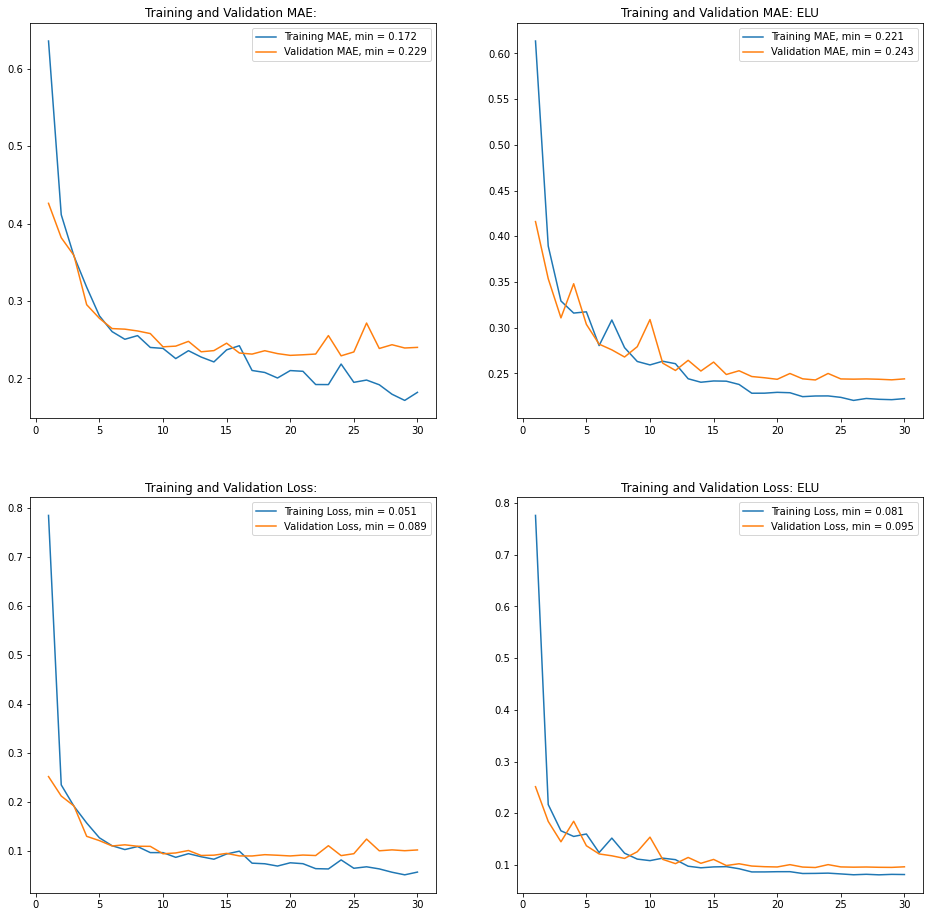

In [0]:
#Plot of the loss function 
plotcompare(history, comp2 = 'ELU')

In [0]:
#Prediction usage
predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)

Predicted vs True T: 0.742502 VS 0.102209 Diff= 0.640293
Predicted vs True T: 1.211500 VS 1.384770 Diff= -0.173270
Predicted vs True T: 2.640942 VS 2.531030 Diff= 0.109912
Predicted vs True T: 1.219700 VS 1.388530 Diff= -0.168830
Predicted vs True T: 4.300694 VS 3.865890 Diff= 0.434803
Predicted vs True T: 2.990876 VS 3.281270 Diff= -0.290394
Predicted vs True T: 4.323674 VS 4.444750 Diff= -0.121076
Predicted vs True T: 2.999898 VS 3.063080 Diff= -0.063182
Predicted vs True T: 3.695216 VS 3.156730 Diff= 0.538486
Predicted vs True T: 2.934902 VS 2.829210 Diff= 0.105692
Sample MAE:  [0.2645939]


In [0]:
#Accuracy
accuracy_func(model,X_test)

Accuracy is:  0.9795


#4 Keras Tuning:

In [0]:
pip install -U keras-tuner

Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.6/dist-packages (1.0.1)


In [0]:
def build_model(hp):
  inputs = keras.Input(shape=(28,28,1))
  data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip()
  ], name='DataAugm')
  x = data_augmentation(inputs)

  x = keras.layers.Conv2D(
      filters=hp.Int('filters', min_value=16, max_value=128, step=16),
      kernel_size=(3,3))(x)
  x = keras.layers.ReLU()(x)
  x = keras.layers.MaxPool2D((2,2))(x)

  x = keras.layers.Conv2D(
    filters=hp.Int('filters', min_value=32, max_value=128, step=32),
    kernel_size=(3,3))(x)
  x = keras.layers.ReLU()(x)
  x = keras.layers.MaxPool2D((2,2))(x)
  
  x = keras.layers.Conv2D(
    filters=hp.Int('filters', min_value=32, max_value=128, step=32),
    kernel_size=(3,3))(x)
  x = keras.layers.ReLU()(x)

  x = keras.layers.Flatten()(x)

  x = keras.layers.Dense(
      units=hp.Int('units', min_value=32, max_value=512, step=32)
      )(x)
  x = keras.layers.ReLU()(x)

  x = keras.layers.Dense(
      units=hp.Int('units', min_value=32, max_value=512, step=32)
      )(x)
  x = keras.layers.ReLU()(x)

  outputs = keras.layers.Dense(1)(x)

  model = keras.Model(inputs=inputs, outputs=outputs)
  
  model.compile(
        optimizer=keras.optimizers.Adam(
          hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=['mae'])
  
  return model


In [0]:
import kerastuner
 
tuner = kerastuner.tuners.RandomSearch(
  build_model,
  objective='val_loss',
  max_trials=10,
  executions_per_trial=2,
  directory='ottim_dir')

X_t,X_v,Y_t,Y_v=train_test_split(X_train,Y_train,train_size=0.5)

tuner.search(X_t, Y_t, epochs=10, validation_data=(X_v, Y_v))

INFO:tensorflow:Reloading Oracle from existing project ottim_dir/untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ottim_dir/untitled_project/tuner0.json
INFO:tensorflow:Oracle triggered exit


In [0]:
# Results
tuner.results_summary()

In [0]:
# Retrieve the best models
models = tuner.get_best_models(num_models=3)

for index,j in enumerate(models):
  test_loss, test_mae = models[index].evaluate(X_test,  Y_test, verbose=2)
  print('\nTest loss',index+1,' (MSE):', test_loss)
  print('\nTest ',index+1,' MAE:', test_mae)

63/63 - 0s - loss: 0.0840 - mae: 0.2233

Test loss 1  (MSE): 0.08399315178394318

Test  1  MAE: 0.22333776950836182
63/63 - 0s - loss: 0.0903 - mae: 0.2320

Test loss 2  (MSE): 0.09026754647493362

Test  2  MAE: 0.23204554617404938
63/63 - 0s - loss: 0.0860 - mae: 0.2265

Test loss 3  (MSE): 0.08602739125490189

Test  3  MAE: 0.22650592029094696


In [0]:
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath = 'best_epoch',
        verbose = 0,
        save_weights_only = True, 
        save_freq = 'epoch',
        save_best_only = True,
        mode ='min')

callbacks = [ lr_scheduler, model_checkpoint ]

history = models[0].fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)


Epoch 1/30
50/50 [==============================] - 0s 7ms/step - loss: 0.0866 - mae: 0.2278 - val_loss: 0.0904 - val_mae: 0.2365 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 0s 6ms/step - loss: 0.0878 - mae: 0.2292 - val_loss: 0.0922 - val_mae: 0.2354 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 0s 6ms/step - loss: 0.0840 - mae: 0.2233 - val_loss: 0.0812 - val_mae: 0.2231 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 0s 6ms/step - loss: 0.0831 - mae: 0.2205 - val_loss: 0.0872 - val_mae: 0.2289 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 0s 6ms/step - loss: 0.0819 - mae: 0.2197 - val_loss: 0.0893 - val_mae: 0.2301 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - 0s 6ms/step - loss: 0.0810 - mae: 0.2182 - val_loss: 0.0828 - val_mae: 0.2234 - lr: 0.0010
Epoch 7/30
50/50 [==============================] - 0s 6ms/step - loss: 0.0842 - mae: 0.2218 - val_loss: 0.0808 - val_mae: 0.2220 - lr: 0.0010

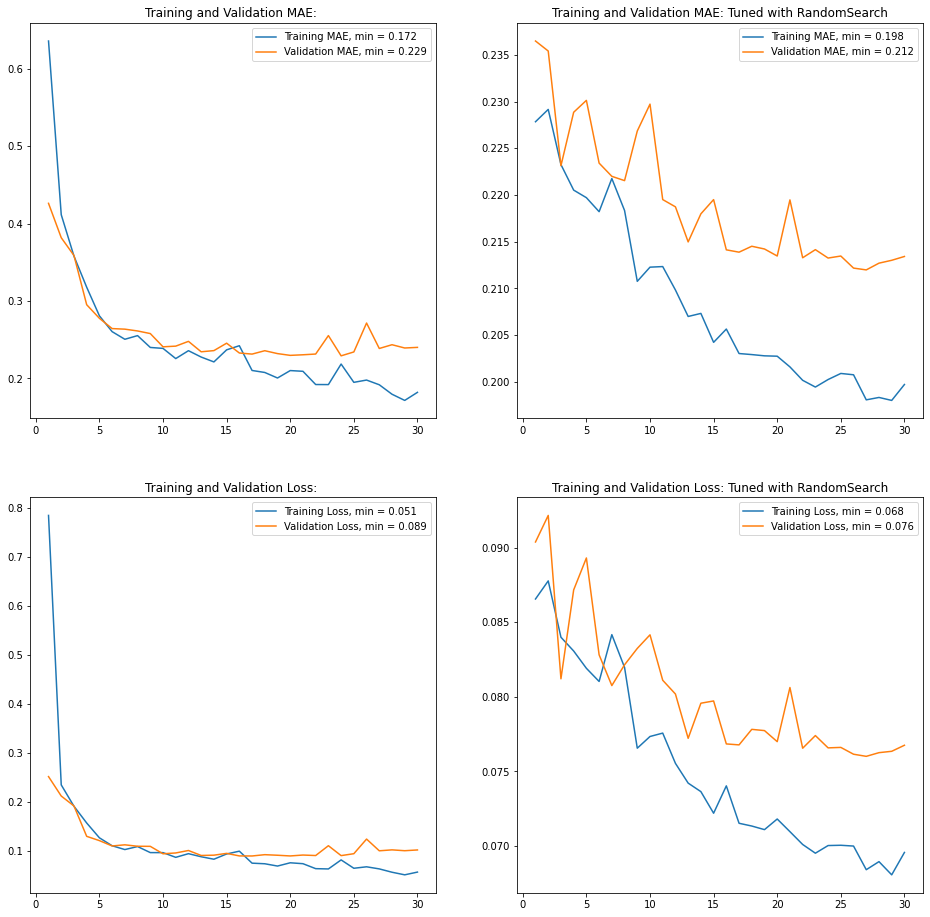

In [0]:
  plt.close()
  comp1=''
  comp2='Tuned with RandomSearch'
  mae_lrd = history.history['mae']
  val_mae_lrd = history.history['val_mae']

  loss_lrd=history.history['loss']
  val_loss_lrd=history.history['val_loss']

  #Calculating the minimum reached
  min_mae = np.amin(mae)
  min_val_mae = np.amin(val_mae)

  min_mae_lrd = np.amin(mae_lrd)
  min_val_mae_lrd = np.amin(val_mae_lrd)

  min_loss = np.amin(loss)
  min_val_loss = np.amin(val_loss)

  min_loss_lrd = np.amin(loss_lrd)
  min_val_loss_lrd = np.amin(val_loss_lrd)

  epochs_range = range(1, len(loss) + 1)

  fig, axarr = plt.subplots(nrows=2, ncols=2, figsize = ((8*2,8*2)))

  axarr[0,0].plot(epochs_range, mae, label='Training MAE, min = %.3f'%min_mae)
  axarr[0,0].plot(epochs_range, val_mae, label='Validation MAE, min = %.3f'%min_val_mae)
  axarr[0,0].legend(loc='upper right')
  axarr[0,0].set_title('Training and Validation MAE: %s'%comp1)

  axarr[0,1].plot(epochs_range, mae_lrd, label='Training MAE, min = %.3f'%min_mae_lrd)
  axarr[0,1].plot(epochs_range, val_mae_lrd, label='Validation MAE, min = %.3f'%min_val_mae_lrd)
  axarr[0,1].legend(loc='upper right')
  axarr[0,1].set_title('Training and Validation MAE: %s'%comp2)

  axarr[1,0].plot(epochs_range, loss, label='Training Loss, min = %.3f'%min_loss)
  axarr[1,0].plot(epochs_range, val_loss, label='Validation Loss, min = %.3f'%min_val_loss)
  axarr[1,0].legend(loc='upper right')
  axarr[1,0].set_title('Training and Validation Loss: %s'%comp1)

  axarr[1,1].plot(epochs_range, loss_lrd, label='Training Loss, min = %.3f'%min_loss_lrd)
  axarr[1,1].plot(epochs_range, val_loss_lrd, label='Validation Loss, min = %.3f'%min_val_loss_lrd)
  axarr[1,1].legend(loc='upper right')
  axarr[1,1].set_title('Training and Validation Loss: %s'%comp2)
  plt.show()

In [0]:
predictions = models[1].predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)

Predicted vs True T: 0.743765 VS 0.102209 Diff= 0.641556
Predicted vs True T: 1.281641 VS 1.384770 Diff= -0.103129
Predicted vs True T: 2.566511 VS 2.531030 Diff= 0.035481
Predicted vs True T: 1.330196 VS 1.388530 Diff= -0.058334
Predicted vs True T: 4.279933 VS 3.865890 Diff= 0.414043
Predicted vs True T: 3.219726 VS 3.281270 Diff= -0.061544
Predicted vs True T: 4.380867 VS 4.444750 Diff= -0.063883
Predicted vs True T: 3.017903 VS 3.063080 Diff= -0.045177
Predicted vs True T: 3.620099 VS 3.156730 Diff= 0.463369
Predicted vs True T: 2.723499 VS 2.829210 Diff= -0.105711
Sample MAE:  [0.19922283]


In [0]:
for index,J in enumerate(models):
  accuracy_func(models[index],X_test)

Accuracy is:  0.9855
Accuracy is:  0.978
Accuracy is:  0.9795


# 5 Batch Normalization Layers

In [0]:
def create_batched_convolution(activation = 'ReLU', n_conv = 3, n_pool = 2, n_dense = 2, conv2D = 32, density = 256, augmentation = 'TRUE'):
  inputs = keras.Input(shape=(28,28,1))

  if augmentation == 'TRUE':
    data_augmentation = keras.Sequential([
      keras.layers.experimental.preprocessing.RandomFlip()
    ], name='DataAugm')
    x = data_augmentation(inputs)
  elif augmentation == 'FALSE': x = inputs
  else: 
    print('Error! "augmentation" must be a boolean variable.')
    return None

  #Normal layers
  for index in range(n_conv):
    nameconv = 'Conv_'+str(index+1) 
    nameact = activation+'_'+str(index+1)
    namepool = 'MaxPool_'+str(index+1)
    
    if index == 0:
      x = keras.layers.Conv2D(conv2D, kernel_size=(3,3), name=nameconv)(x)
    else: 
      x = keras.layers.Conv2D(conv2D*2, kernel_size=(3,3), name=nameconv)(x)

    x = keras.layers.BatchNormalization()(x)

    if activation == 'ReLU':
      x = keras.layers.ReLU(name=nameact)(x)
    elif activation == 'ELU':
      x = keras.layers.ELU(name=nameact)(x)
    elif activation == 'LeakyReLU':
      x = keras.layers.LeakyReLU(name=nameact)(x)
    elif activation == 'tanh':
      x = keras.layers.Activation(activation,name=nameact)(x)
    else: 
      print('Error! Activation function is not valid')
      return None

    if index < n_pool:
      x = keras.layers.MaxPool2D((2,2), name=namepool)(x)

  x = keras.layers.Flatten(name='Flatten')(x)

  #Dense layers
  for index in range(n_dense):
    namedense = 'Dense_'+str(index+1) 
    nameact = activation+'_Dense_'+str(index+1)

    x = keras.layers.Dense(density, name=namedense)(x)
    if activation == 'ReLU':
      x = keras.layers.ReLU(name=nameact)(x)
    elif activation == 'ELU':
      x = keras.layers.ELU(name=nameact)(x)
    elif activation == 'LeakyReLU':
      x = keras.layers.LeakyReLU(name=nameact)(x)
    elif activation == 'tanh':
      x = keras.layers.Activation(activation,name=nameact)(x)
    else: 
      print('Error! Activation function is not valid')
      return None

  outputs = keras.layers.Dense(1, name='Output')(x)
  model = keras.Model(inputs=inputs, outputs=outputs, name='ising_CNN')
 
  return outputs, model

In [0]:
outputs, model = create_batched_convolution(activation='LeakyReLU')

In [0]:
#Compilation of the model
LR_ST=1e-3

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)
#Metrics
mse_lrd = tf.keras.losses.MeanSquaredError()
mae_lrd = tf.keras.metrics.MeanAbsoluteError()

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse_lrd,
              metrics=[mae_lrd],
              run_eagerly=EAGERLY)

In [0]:
#Training and callback modification
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath = 'best_epoch',
        verbose = 0,
        save_weights_only = True, 
        save_freq = 'epoch',
        save_best_only = True,
        mode ='min')

callbacks = [ lr_scheduler, model_checkpoint ]

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 0s 9ms/step - loss: 0.7170 - mean_absolute_error: 0.5995 - val_loss: 7.1606 - val_mean_absolute_error: 2.2332 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 0s 6ms/step - loss: 0.2623 - mean_absolute_error: 0.4045 - val_loss: 7.9626 - val_mean_absolute_error: 2.3722 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 0s 7ms/step - loss: 0.2015 - mean_absolute_error: 0.3551 - val_loss: 7.0808 - val_mean_absolute_error: 2.1949 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1900 - mean_absolute_error: 0.3425 - val_loss: 6.7538 - val_mean_absolute_error: 2.1371 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1717 - mean_absolute_error: 0.3264 - val_loss: 6.3573 - val_mean_absolute_error: 2.0445 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1700 - mean_absolute_error: 0.3241 - val_loss: 4.72

In [0]:
model.load_weights('best_epoch')

#Accuracy check
test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.0930 - mean_absolute_error: 0.2354

Test loss (MSE): 0.09303440153598785

Test MAE: 0.23543928563594818


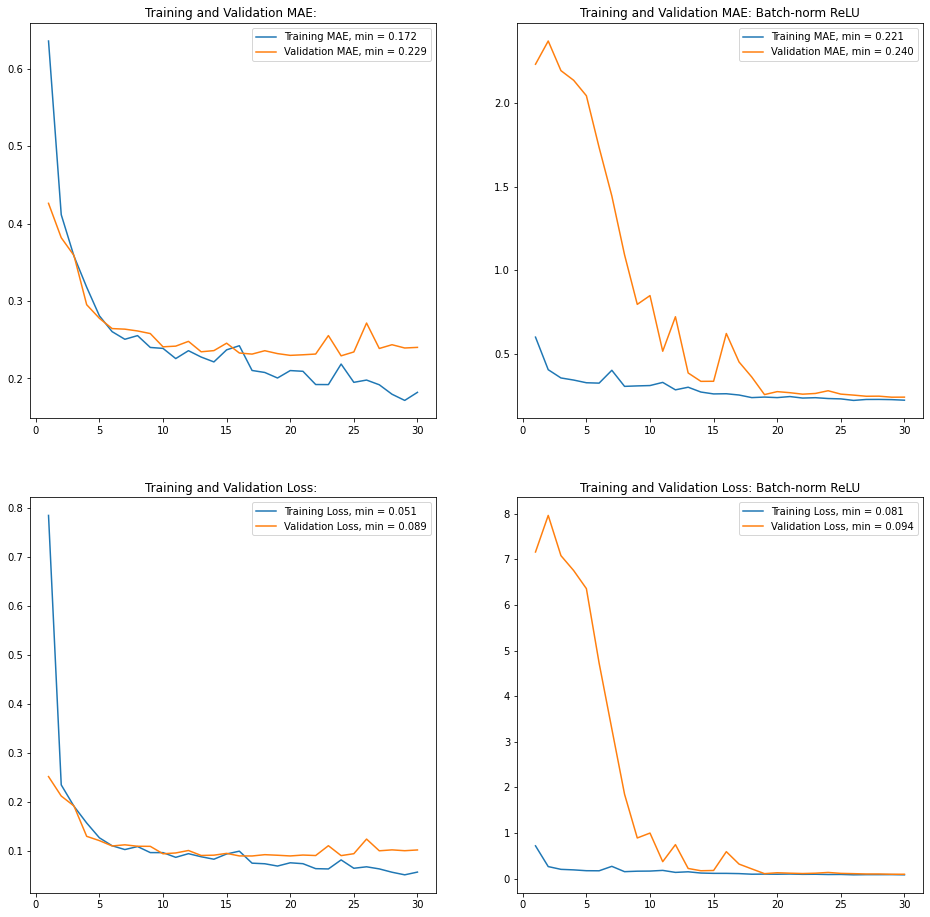

In [0]:
#Plot of the loss function 
plotcompare(history, comp2 = 'Batch-norm ReLU')

In [0]:
#Prediction usage
predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)

Predicted vs True T: 0.625949 VS 0.102209 Diff= 0.523740
Predicted vs True T: 1.203612 VS 1.384770 Diff= -0.181158
Predicted vs True T: 2.515353 VS 2.531030 Diff= -0.015677
Predicted vs True T: 1.256060 VS 1.388530 Diff= -0.132470
Predicted vs True T: 3.920860 VS 3.865890 Diff= 0.054970
Predicted vs True T: 3.239840 VS 3.281270 Diff= -0.041430
Predicted vs True T: 4.477065 VS 4.444750 Diff= 0.032315
Predicted vs True T: 3.213180 VS 3.063080 Diff= 0.150100
Predicted vs True T: 3.834874 VS 3.156730 Diff= 0.678144
Predicted vs True T: 2.888584 VS 2.829210 Diff= 0.059374
Sample MAE:  [0.18693775]


In [0]:
#Accuracy
accuracy_func(model,X_test)

Accuracy is:  0.9725


**Trovare gi iprparametri ottimali del modello con** *Keras Tuner*

Dato un modello funzionante il passo successivo è quello di ottimizzarne l'archiettura. Questo può essere fatto manualmente (alcuni esempi li abbiamo visti sopra intorducendo il decay del learning rate o introducendo procedure di data_augmentation), oppure in modo sistematico usando tool appositi. Uno di tali tool, semplice e che funziona con keras è appunto [*Keras Tuner*](https://keras-team.github.io/keras-tuner/)


Uso:

1.   si modifica la definizione del modello in modo che acectti un parametro *hp* e in modo tale da modificare gli iperparametri del modello in accordo a diversi metodi di sampling *(hp.Int(), hp.Choice(), ...)*  
2.   si istanzia un oggetto di tipo *tuner* che definisce la strategia di tuning da seguire
3.   si fa partire la ricerca dei parametri e si prina il risultato finale

Esempio pratico: